In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from numpy.matlib import repmat
import sympy
from sympy import *

In [2]:
def transform(X, mod):
    
    if mod==0:
        r_X = X[1,0:2] - X[3,0:2]
    elif mod==1:
        r_X = X[3,0:2] - X[1,0:2]
    
    r = locations[3,:] - locations[1,:]
    theta = -np.arccos(np.dot(r,r_X)/(LA.norm(r_X)*LA.norm(r)))

    c, s = np.cos(theta), np.sin(theta)
    rotation = np.array(((c, -s), (s, c)))
    translation = -np.dot(X[2,0:2], np.transpose(rotation))
    #test = np.transpose(np.dot(rotation, np.transpose(X[:,0:2]))) + repmat(translation, 4, 1)
    test = 1
    #estimate_source = np.transpose(np.dot(rotation, np.transpose(X[0,0:2])) + translation)
    estimate_source = np.dot(X[0,0:2], np.transpose(rotation)) + translation
    
    return estimate_source, test

In [3]:
error_range = np.linspace(0,1,11)

In [4]:
mean_MSE_MDS_big = []
number_solved_MDS_big = []
number_unsolved_MDS_big = []

for error in error_range:
    MSE = []
    solved = 0
    unsolved = 0

    for ran_idx in range(100):

        random.seed(ran_idx)
        np.random.seed(ran_idx)

        source = [random.uniform(-5,5),random.uniform(0,10)]
        mic1 = [-2,1]
        mic2 = [0,0]
        mic3 = [2,1]

        #source = [0,25]
        #mic1 = [-12,9]
        #mic2 = [0,0]
        #mic3 = [12,9]

        locations = np.zeros([4,2])
        locations[0] = source
        locations[1] = mic1
        locations[2] = mic2
        locations[3] = mic3

        mu = np.array([0,0,0])
        sigma = np.array([error,error,error])
        noise = np.random.normal(mu,sigma)

        D = np.zeros([4,4])

        for i in range(4):
            for j in range((i+1),4):
                if i == 0:
                    D[i,j] = (np.sqrt((locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2)+ noise[j-1])**2
                    D[j,i] = D[i,j]
                else:
                    D[i,j] = (locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2
                    D[j,i] = D[i,j]

        a = np.ones([1,4])/4
        J = 1/2**0.5 * np.transpose((np.eye(4) - np.ones([4,1]) * a))

        K = - LA.multi_dot([np.transpose(J), D, J])

        Lambda, U = LA.eig(K)

        idx = np.abs(Lambda).argsort()[::-1]
        Lambda = Lambda[idx]
        U = U[:,idx]

        rank = LA.matrix_rank(D)
        Lambda = Lambda[:2]
        if Lambda[1] < 0:
            Lambda[1] = - Lambda[1]
            
        U = np.round(U[:,:2],4)
        if U[0,0] > 0:
            U[:,0] = - U[:,0]

        U0 = U.copy()
        U1 = U.copy()

        U1[:,1] = - U1[:,1]

        X0 = np.dot(U0, np.sqrt(np.round(np.diag(Lambda),4)))
        X1 = np.dot(U1, np.sqrt(np.round(np.diag(Lambda),4)))

        estimations = np.zeros([4,2])
        mse = np.zeros([4,1])

        estimations[0,:], test00 = transform(X0, mod=0)
        estimations[1,:], test01 = transform(X0, mod=1)
        estimations[2,:], test10 = transform(X1, mod=0)
        estimations[3,:], test11 = transform(X1, mod=1)

        mse[0] = (estimations[0,0]-locations[0,0])**2 + (estimations[0,1]-locations[0,1])**2
        mse[1] = (estimations[1,0]-locations[0,0])**2 + (estimations[1,1]-locations[0,1])**2
        mse[2] = (estimations[2,0]-locations[0,0])**2 + (estimations[2,1]-locations[0,1])**2
        mse[3] = (estimations[3,0]-locations[0,0])**2 + (estimations[3,1]-locations[0,1])**2

        min_mse = np.min(mse)
        min_idx = np.argmin(mse)
        estimate_source = estimations[min_idx,:]

        if min_mse > 1:
            unsolved += 1
        else:  
            MSE.append(min_mse)
            solved += 1
    
    mean_MSE_MDS_big.append(np.mean(MSE))
    number_solved_MDS_big.append(solved)
    number_unsolved_MDS_big.append(unsolved)

print(mean_MSE_MDS_big)
print(number_solved_MDS_big)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part


[0.002152959510487276, 0.06981390291289818, 0.19747280470883355, 0.28206272349342054, 0.3211464064365393, 0.33696312083726365, 0.39707654921452396, 0.4090247351929285, 0.4212294038215633, 0.4092686121297986, 0.38226686406272253]
[100, 100, 97, 86, 73, 64, 56, 46, 37, 32, 29]


In [5]:
mean_MSE_MDS_small = []
number_solved_MDS_small = []
number_unsolved_MDS_small = []

for error in error_range:
    MSE = []
    solved = 0
    unsolved = 0

    for ran_idx in range(100):

        random.seed(ran_idx)
        np.random.seed(ran_idx)

        source = [random.uniform(-3,3),random.uniform(0,5)]
        mic1 = [-2,1]
        mic2 = [0,0]
        mic3 = [2,1]

        #source = [0,25]
        #mic1 = [-12,9]
        #mic2 = [0,0]
        #mic3 = [12,9]

        locations = np.zeros([4,2])
        locations[0] = source
        locations[1] = mic1
        locations[2] = mic2
        locations[3] = mic3

        mu = np.array([0,0,0])
        sigma = np.array([error,error,error])
        noise = np.random.normal(mu,sigma)

        D = np.zeros([4,4])

        for i in range(4):
            for j in range((i+1),4):
                if i == 0:
                    D[i,j] = (np.sqrt((locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2)+ noise[j-1])**2
                    D[j,i] = D[i,j]
                else:
                    D[i,j] = (locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2
                    D[j,i] = D[i,j]

        a = np.ones([1,4])/4
        J = 1/2**0.5 * np.transpose((np.eye(4) - np.ones([4,1]) * a))

        K = - LA.multi_dot([np.transpose(J), D, J])

        Lambda, U = LA.eig(K)

        idx = np.abs(Lambda).argsort()[::-1]
        Lambda = Lambda[idx]
        U = U[:,idx]

        rank = LA.matrix_rank(D)
        Lambda = Lambda[:2]
        if Lambda[1] < 0:
            Lambda[1] = - Lambda[1]
            
        U = np.round(U[:,:2],4)
        if U[0,0] > 0:
            U[:,0] = - U[:,0]

        U0 = U.copy()
        U1 = U.copy()

        U1[:,1] = - U1[:,1]

        X0 = np.dot(U0, np.sqrt(np.round(np.diag(Lambda),4)))
        X1 = np.dot(U1, np.sqrt(np.round(np.diag(Lambda),4)))

        estimations = np.zeros([4,2])
        mse = np.zeros([4,1])

        estimations[0,:], test00 = transform(X0, mod=0)
        estimations[1,:], test01 = transform(X0, mod=1)
        estimations[2,:], test10 = transform(X1, mod=0)
        estimations[3,:], test11 = transform(X1, mod=1)

        mse[0] = (estimations[0,0]-locations[0,0])**2 + (estimations[0,1]-locations[0,1])**2
        mse[1] = (estimations[1,0]-locations[0,0])**2 + (estimations[1,1]-locations[0,1])**2
        mse[2] = (estimations[2,0]-locations[0,0])**2 + (estimations[2,1]-locations[0,1])**2
        mse[3] = (estimations[3,0]-locations[0,0])**2 + (estimations[3,1]-locations[0,1])**2

        min_mse = np.min(mse)
        min_idx = np.argmin(mse)
        estimate_source = estimations[min_idx,:]

        if min_mse > 1:
            unsolved += 1
        else:  
            MSE.append(min_mse)
            solved += 1
    
    mean_MSE_MDS_small.append(np.mean(MSE))
    number_solved_MDS_small.append(solved)
    number_unsolved_MDS_small.append(unsolved)

print(mean_MSE_MDS_small)
print(number_solved_MDS_small)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part


[0.002523567169277963, 0.03165621210889029, 0.11534749167739353, 0.21169324648111135, 0.28966000315076373, 0.31282640494877617, 0.3474300601038602, 0.3890086555085171, 0.3947744595156556, 0.3816938776162089, 0.3886947068051721]
[100, 100, 100, 97, 91, 77, 68, 64, 58, 49, 42]


In [6]:
mean_MSE_TDoA_big = []
number_solved_TDoA_big = []
number_unsolved_TDoA_big = []

for error in error_range:
    MSE = []
    solved = 0
    unsolved = 0

    for ran_idx in range(100):
        try:
            random.seed(ran_idx)
            np.random.seed(ran_idx)
            source = [random.uniform(-5,5),random.uniform(0,10)]
            mic1 = [-2,1]
            mic2 = [0,0]
            mic3 = [2,1]

            locations = np.zeros([4,2])
            locations[0] = source
            locations[1] = mic1
            locations[2] = mic2
            locations[3] = mic3

            mu = np.array([0,0,0])
            sigma = np.array([error,error,error])

            noise = np.random.normal(mu,sigma)

            d1 = np.sqrt((locations[0,0]-locations[1,0])**2 + (locations[0,1]-locations[1,1])**2) + noise[0]
            d2 = np.sqrt((locations[0,0]-locations[2,0])**2 + (locations[0,1]-locations[2,1])**2) + noise[1]
            d3 = np.sqrt((locations[0,0]-locations[3,0])**2 + (locations[0,1]-locations[3,1])**2) + noise[2]

            d_diff = np.array([d1-d2,d1-d3,d2-d3])

            def f(x,y,idx):
                return ((x-locations[idx,0])**2 + (y-locations[idx,1])**2)**0.5

            x = Symbol('x')
            y = Symbol('y')

            try:
                soln = nsolve([f(x,y,1)-f(x,y,2)-d_diff[0], f(x,y,1)-f(x,y,3)-d_diff[1], f(x,y,2)-f(x,y,3)-d_diff[2]],[x,y],[-2.5,5])
            except:
                soln = nsolve([f(x,y,1)-f(x,y,2)-d_diff[0], f(x,y,1)-f(x,y,3)-d_diff[1], f(x,y,2)-f(x,y,3)-d_diff[2]],[x,y],[2.5,5])

            mse = (soln[0]-locations[0,0])**2 + (soln[1]-locations[0,1])**2

            if mse > 1:
                unsolved += 1
            else:
                solved += 1
                MSE.append(mse)

        except:
            #print('unable to solve')
            unsolved += 1
            continue

    mean_MSE_TDoA_big.append(np.mean(MSE))
    number_solved_TDoA_big.append(solved)
    
print(mean_MSE_TDoA_big)
print(number_solved_TDoA_big)

[0.00103954603641631, 0.358374249598781, 0.352376264856103, 0.325285958931176, 0.512631606148927, 0.633966951811750, 0.536447411595657, 0.338085860904677, 0.342840168908608, 0.102644076445897, 0.128115157909146]
[94, 37, 20, 13, 12, 9, 5, 3, 3, 2, 2]


In [7]:
mean_MSE_TDoA_small = []
number_solved_TDoA_small = []
number_unsolved_TDoA_small = []

for error in error_range:
    MSE = []
    solved = 0
    unsolved = 0

    for ran_idx in range(100):
        try:
            random.seed(ran_idx)
            np.random.seed(ran_idx)
            source = [random.uniform(-3,3),random.uniform(0,5)]
            mic1 = [-2,1]
            mic2 = [0,0]
            mic3 = [2,1]

            locations = np.zeros([4,2])
            locations[0] = source
            locations[1] = mic1
            locations[2] = mic2
            locations[3] = mic3

            mu = np.array([0,0,0])
            sigma = np.array([error,error,error])

            noise = np.random.normal(mu,sigma)

            d1 = np.sqrt((locations[0,0]-locations[1,0])**2 + (locations[0,1]-locations[1,1])**2) + noise[0]
            d2 = np.sqrt((locations[0,0]-locations[2,0])**2 + (locations[0,1]-locations[2,1])**2) + noise[1]
            d3 = np.sqrt((locations[0,0]-locations[3,0])**2 + (locations[0,1]-locations[3,1])**2) + noise[2]

            d_diff = np.array([d1-d2,d1-d3,d2-d3])

            def f(x,y,idx):
                return ((x-locations[idx,0])**2 + (y-locations[idx,1])**2)**0.5

            x = Symbol('x')
            y = Symbol('y')

            try:
                soln = nsolve([f(x,y,1)-f(x,y,2)-d_diff[0], f(x,y,1)-f(x,y,3)-d_diff[1], f(x,y,2)-f(x,y,3)-d_diff[2]],[x,y],[-2.5,5])
            except:
                soln = nsolve([f(x,y,1)-f(x,y,2)-d_diff[0], f(x,y,1)-f(x,y,3)-d_diff[1], f(x,y,2)-f(x,y,3)-d_diff[2]],[x,y],[2.5,5])

            mse = (soln[0]-locations[0,0])**2 + (soln[1]-locations[0,1])**2

            if mse > 1:
                unsolved += 1
            else:
                solved += 1
                MSE.append(mse)

        except:
            #print('unable to solve')
            unsolved += 1
            continue

    mean_MSE_TDoA_small.append(np.mean(MSE))
    number_solved_TDoA_small.append(solved)
    
print(mean_MSE_TDoA_small)
print(number_solved_TDoA_small)

[1.22604597038648e-29, 0.236490618429010, 0.334012774984773, 0.390491986879210, 0.419243147625995, 0.377610488649600, 0.457297693990721, 0.506735502595836, 0.582936577944119, 0.552041343281238, 0.528500341017002]
[93, 75, 53, 37, 25, 17, 15, 12, 11, 8, 6]


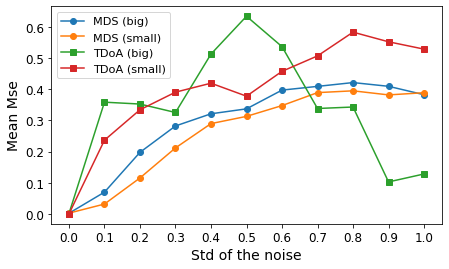

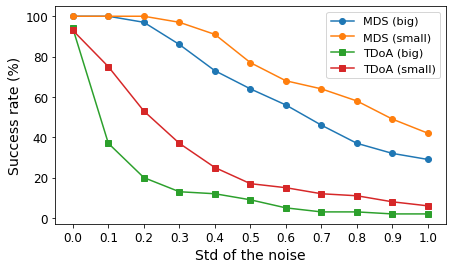

In [57]:
plt.figure(figsize=(7,4))
#plt.subplot(1,2,1)
plt.plot(mean_MSE_MDS_big, marker='o', label='MDS (big)')
plt.plot(mean_MSE_MDS_small, marker='o', label='MDS (small)')
plt.plot(mean_MSE_TDoA_big, marker='s', label='TDoA (big)')
plt.plot(mean_MSE_TDoA_small, marker='s', label='TDoA (small)')
plt.xticks(np.linspace(0,10,11), np.round(error_range, 2))
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlabel('Std of the noise', fontsize='14')
plt.ylabel('Mean Mse', fontsize='14')
plt.legend(loc='upper left', fontsize='11.3')

plt.figure(figsize=(7,4))
#plt.subplot(1,2,2)
plt.plot(number_solved_MDS_big, marker='o', label='MDS (big)')
plt.plot(number_solved_MDS_small, marker='o', label='MDS (small)')
plt.plot(number_solved_TDoA_big, marker='s', label='TDoA (big)')
plt.plot(number_solved_TDoA_small, marker='s', label='TDoA (small)')
plt.xticks(np.linspace(0,10,11), np.round(error_range, 2))
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.xlabel('Std of the noise', fontsize='14')
plt.ylabel('Success rate (%)', fontsize='14')
plt.legend(loc='upper right', fontsize='11.3')